<a href="https://colab.research.google.com/github/GoogleCloudPlatform/tf-estimator-tutorials/blob/master/00_Miscellaneous/text-similarity-analysis/bqml/classification_with_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
from google.cloud import bigquery
client = bigquery.Client(project='YOUR-PROJECT-NAME')

## Table Schema

In [3]:
dataset_id = 'YOUR-DATASET-NAME'
table_id = 'YOUR-TABLE-NAME'

dataset_ref = client.dataset(dataset_id)
table_ref = dataset_ref.table(table_id)
table = client.get_table(table_ref)

# View table properties
for e in table.schema:
  print(e)

SchemaField('topics', 'STRING', 'NULLABLE', None, ())
SchemaField('title', 'STRING', 'NULLABLE', None, ())
SchemaField('content', 'STRING', 'NULLABLE', None, ())
SchemaField('title_embed', 'FLOAT', 'REPEATED', None, ())
SchemaField('content_embed', 'FLOAT', 'REPEATED', None, ())


##Create Features

In [0]:
def get_flattened_embeddings(input_column='content_embed', n=512):
  L = []
  for i in range(n):
    L.append("{0}[OFFSET({1})] AS {0}_{1}".format(input_column, i))
  return (',').join(L)

def get_one_hot_vectors(input_column='topics', categories=['acl','gas']):
  L = []
  for cat in categories:
    L.append(
      "CASE WHEN '{1}' in UNNEST(SPLIT({0})) THEN 1 ELSE 0 END as {1}".format(
        input_column, cat))
  return (',').join(L)

def get_number(input_column='topics', categories=['acl','gas']):
  L = []
  for cat in categories:
    L.append(
      "(CASE WHEN '{1}' in UNNEST(SPLIT({0})) THEN 1 ELSE 0 END)".format(
        input_column, cat))
  return ('+').join(L)

In [0]:
def get_topics_and_count(dataset_id, table_id):
  sql = """
  WITH topics_flatten AS
  (
  SELECT topic FROM
    (
    SELECT 
      SPLIT(topics, ',') AS topic
    FROM
      `{0}.{1}`
    WHERE
      topics != ''
    ),
    unnest(topic) topic
  )

  SELECT 
    REPLACE(topic, '-', '_') AS topic,
    count(*) AS count
  FROM
    topics_flatten
  GROUP BY
    topic
  """.format(dataset_id, table_id)
  return sql

df = client.query(get_topics_and_count(dataset_id, table_id)).to_dataframe()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0f4f893668>]],
      dtype=object)

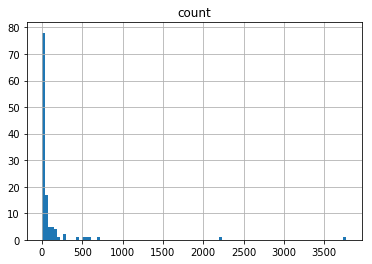

In [6]:
df.hist(bins=100)

In [7]:
target_categories = list(df[df['count'] >= 100].topic)
target_categories[:2]

['acq', 'bop']

In [8]:
def create_dataset(
    dataset_id, table_id, categories=['acq'], embed='content_embed', n=512):
  sql = """
  CREATE OR REPLACE TABLE `{0}.input_data`
    AS
    (
      SELECT
        STRUCT( {2} ) AS label,
        STRUCT( {3} ) AS feature
      FROM
        `{0}.{1}`
      WHERE
        {4} > 0
    )
  """.format(
      dataset_id, table_id,
      get_one_hot_vectors(input_column='topics', categories=categories),
      get_flattened_embeddings(input_column=embed, n=n),
      get_number(input_column='topics', categories=categories))
  return sql

sql = create_dataset(
  dataset_id, table_id,
  categories=target_categories, embed='content_embed', n = 512)
client.query(sql)

## Create Models

In [9]:
def create_model(dataset_id, target='acq'):
  sql = """
  CREATE OR REPLACE MODEL `{0}.model_{1}`
  OPTIONS (
      model_type='logistic_reg',
      input_label_cols=['label']) AS
  SELECT
      label.{1} as label,
      feature.*
  FROM
      `{0}.input_data`
  """.format(dataset_id, target)

  return sql

sql = create_model(dataset_id, target='acq')
client.query(sql)

## Evaluate Models

In [10]:
def evaluate_model(dataset_id, target='acq', threshold=0.55):
  sql = """
  SELECT
    *
  FROM
    ML.EVALUATE(MODEL `{0}.model_{1}`,
      (
      SELECT
        label.{1} as label,
        feature.*
      FROM
        `{0}.input_data`),
      STRUCT({2} AS threshold))
  """.format(dataset_id, target, threshold)
  return sql
    
sql = evaluate_model(dataset_id, target='acq', threshold=0.55)
client.query(sql).to_dataframe()

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.664107,0.9,0.864719,0.764265,0.395869,0.948135


In [0]:
def evaluate_model_roc(dataset_id, target='acq'):
  sql = """
  SELECT
    *
  FROM
    ML.ROC_CURVE
    (
      MODEL `{0}.model_{1}`,
      (
        SELECT
          label.{1} as label,
          feature.*
        FROM
          `{0}.input_data`
      )
    )
  """.format(dataset_id, target)
  return sql

sql = evaluate_model_roc(dataset_id, target='acq')
df = client.query(sql).to_dataframe()

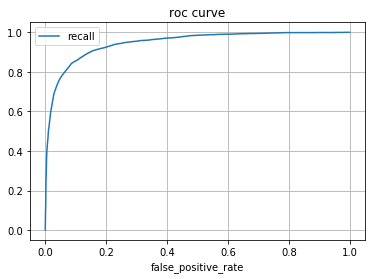

In [12]:
df.plot(x='false_positive_rate', y='recall', grid=True, title='roc curve')

In [0]:
def evaluate_model_pr(target='acq'):
  sql = """
  SELECT
    recall,
    true_positives / (true_positives + false_positives) AS precision
  FROM
    ML.ROC_CURVE(
      MODEL `{0}.model_{1}`,
      (SELECT label.{1} as label, feature.* FROM `{0}.input_data`))
  """.format(dataset_id, target)
  return sql

sql = evaluate_model_pr(target='acq')
df = client.query(sql).to_dataframe()

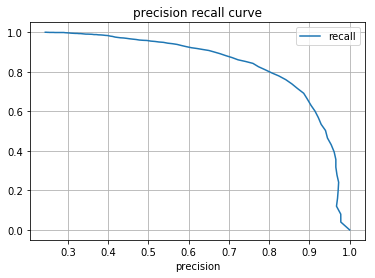

In [14]:
df.plot(x='precision', y='recall', grid=True, title='precision recall curve')

In [15]:
def evaluate_model_confusion_matrix(target='acq'):
    sql = """
    SELECT
      *
    FROM
      ML.CONFUSION_MATRIX(MODEL `{0}.model_{1}`,
      (
        SELECT
          label.{1} as label,
          feature.*
        FROM
          `{0}.input_data`))
    """.format(dataset_id, target)
    return sql

sql = evaluate_model_confusion_matrix(target='acq')
client.query(sql).to_dataframe()

,expected_label,_0,_1
0,0,5610,1250
1,1,181,2029


## Multi-Class Logistic Regression

In [18]:
for target_category in target_categories[:3]:
  print("Creating a model for {0}...".format(target_category))
  client.query(create_model(dataset_id, target=target_category))

Creating a model for acq...
Creating a model for bop...
Creating a model for cpi...


In [25]:
d_cat_to_eval = {}

for target_category in target_categories[:3]:
  print("Evaluating a model for {0}...".format(target_category))
  sql = evaluate_model_roc(dataset_id, target=target_category)
  d_cat_to_eval[target_category] = client.query(sql).to_dataframe()

Evaluating a model for acq...
Evaluating a model for bop...
Evaluating a model for cpi...


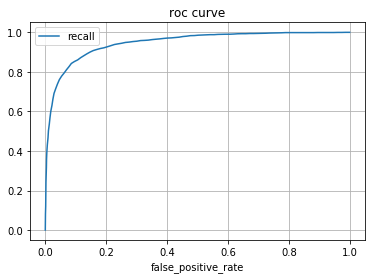

In [26]:
d_cat_to_eval['acq'].plot(x='false_positive_rate', y='recall', grid=True, title='roc curve')

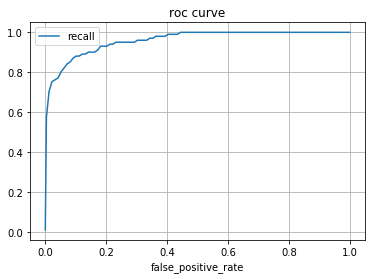

In [27]:
d_cat_to_eval['bop'].plot(x='false_positive_rate', y='recall', grid=True, title='roc curve')

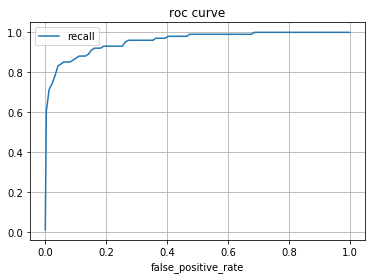

In [28]:
d_cat_to_eval['cpi'].plot(x='false_positive_rate', y='recall', grid=True, title='roc curve')